In [1]:
# Import libraries

import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
import random

# Source dataset (Downloaded dataset)
SOURCE = r"C:\Users\ramit\Downloads\data\natural_images"

# Your Not Corn Leaf destination folder
DEST = r"C:\Users\ramit\OneDrive\Desktop\corn\dataset\Not_Corn_Leaf"

os.makedirs(DEST, exist_ok=True)

count = 0

for folder in os.listdir(SOURCE):

    class_path = os.path.join(SOURCE, folder)

    if os.path.isdir(class_path):

        images = os.listdir(class_path)

        # take random 50 from each folder
        random.shuffle(images)
        images = images[:50]

        for img in images:

            src = os.path.join(class_path, img)
            dst = os.path.join(DEST, f"{folder}_{img}")

            shutil.copy(src, dst)
            count += 1

print(f"{count} images copied to Not_Corn_Leaf")

400 images copied to Not_Corn_Leaf


In [7]:
# SET DATASET PATHS

# PATHS
SOURCE_PATH = r"C:\Users\ramit\OneDrive\Desktop\corn\dataset"
SPLIT_PATH  = r"C:\Users\ramit\OneDrive\Desktop\corn\dataset_split"

# CLEAN OLD SPLIT (Avoid duplication)
if os.path.exists(SPLIT_PATH):
    shutil.rmtree(SPLIT_PATH)

# CREATE TRAIN / TEST FOLDERS
classes = os.listdir(SOURCE_PATH)

for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(SPLIT_PATH, split, cls), exist_ok=True)

print("Train/Test folders created")

# SPLIT DATA (80 / 20)
for cls in classes:
    path = os.path.join(SOURCE_PATH, cls)
    
    images = [
        img for img in os.listdir(path)
        if img.lower().endswith((".jpg",".png",".jpeg"))
    ]

    train_imgs, test_imgs = train_test_split(
        images, test_size=0.2, random_state=42
    )

    for img in train_imgs:
        shutil.copy(os.path.join(path,img),
                    os.path.join(SPLIT_PATH,"train",cls,img))

    for img in test_imgs:
        shutil.copy(os.path.join(path,img),
                    os.path.join(SPLIT_PATH,"test",cls,img))

print("Dataset splitting completed")

Train/Test folders created
Dataset splitting completed


In [8]:
# Data Preprocessing

IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
    SPLIT_PATH + "/train",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    SPLIT_PATH + "/test",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

NUM_CLASSES = train_gen.num_classes
print("Total classes:", NUM_CLASSES)

Found 3668 images belonging to 5 classes.
Found 920 images belonging to 5 classes.
Total classes: 5


In [9]:
# Build CNN Model

model = Sequential([

    Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(IMG_SIZE,IMG_SIZE,3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64,(3,3),activation="relu",padding="same"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128,(3,3),activation="relu",padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Flatten(),

    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(NUM_CLASSES,activation="softmax")
])

optimizer = Adam(learning_rate=0.0004)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

C:\Users\ramit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,485,317 (32.37 MB)

 Trainable params: 8,484,357 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
# Callbacks

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=7,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        "corn_disease_model.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

In [11]:
# Train model

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=35,
    callbacks=callbacks
)

C:\Users\ramit\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8010 - loss: 0.6231 - val_accuracy: 0.2533 - val_loss: 4.8396
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 167s 949ms/step - accuracy: 0.8362 - loss: 0.4408 - val_accuracy: 0.2543 - val_loss: 4.9183
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8591 - loss: 0.3723 - val_accuracy: 0.4380 - val_loss: 1.9087
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8806 - loss: 0.3230 - val_accuracy: 0.8130 - val_loss: 0.5130
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 121s 936ms/step - accuracy: 0.8811 - loss: 0.3067 - val_accuracy: 0.8283 - val_loss: 0.4664
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 104s 903ms/step - accuracy: 0.8953 - loss: 0.2874 - val_accuracy: 0.8207 - val_loss: 0.4351
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 106s 923ms/step - accuracy: 0.9029 - loss: 0.2530 - val_accuracy: 0.8891 - val_loss: 0.2930
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9103 - loss: 0.251

In [12]:
# Evaluate Accuracy

loss, acc = model.evaluate(test_gen)
print(f"TEST ACCURACY: {acc*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.9315 - loss: 0.2031
TEST ACCURACY: 93.15%


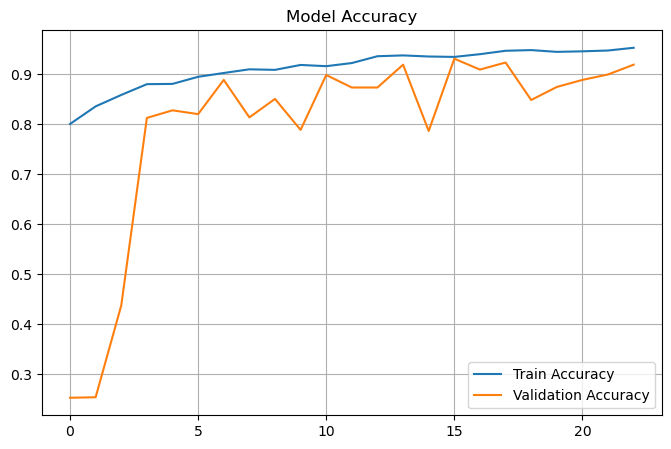

In [13]:
# Plot Graph

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.grid()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step

===== CLASSIFICATION REPORT =====
                precision    recall  f1-score   support

        Blight       0.23      0.22      0.23       230
   Common_Rust       0.29      0.28      0.29       262
Gray_Leaf_Spot       0.10      0.11      0.11       115
       Healthy       0.26      0.26      0.26       233
 Not_Corn_Leaf       0.10      0.10      0.10        80

      accuracy                           0.23       920
     macro avg       0.20      0.20      0.20       920
  weighted avg       0.23      0.23      0.23       920


===== CONFUSION MATRIX GRAPH =====


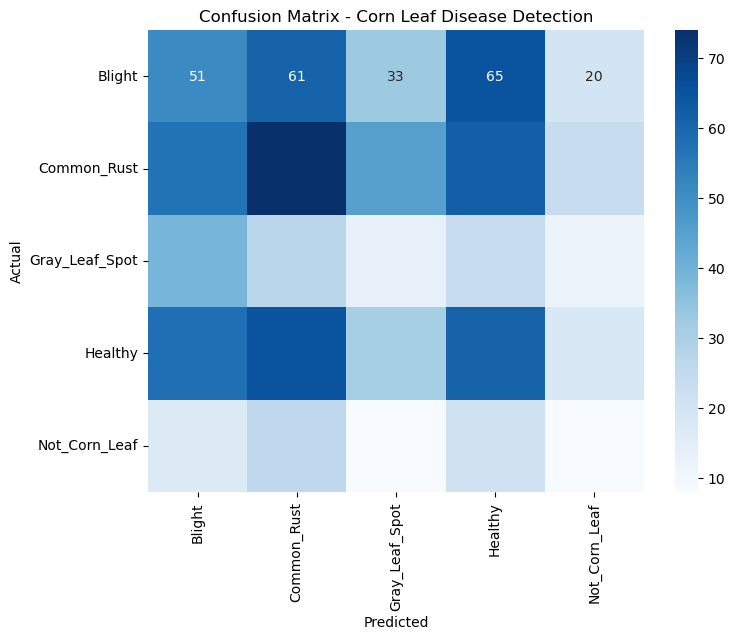

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset generator
test_gen.reset()

# Predictions
pred = model.predict(test_gen)
y_pred = np.argmax(pred, axis=1)
y_true = test_gen.classes

# Class names
class_names = list(test_gen.class_indices.keys())

# === Classification Report ===
report = classification_report(y_true, y_pred, target_names=class_names)
print("\n===== CLASSIFICATION REPORT =====")
print(report)

# ===== CONFUSION MATRIX =====
print("\n===== CONFUSION MATRIX GRAPH =====")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Corn Leaf Disease Detection")

plt.show()

In [16]:
# Save model

model.save("C:/Users/ramit/OneDrive/Desktop/corn/corn_model.keras")
print("\nModel saved successfully!")


Model saved successfully!
